In [11]:
# Imports libraries
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [67]:
# imports data
acc = pd.read_csv('data/Traffic_Accidents.csv')

acc.head(3)

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Accident Number,Date and Time,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Reporting Officer,Collision Type Code,Collision Type Description,...,Harmful Description,Street Address,City,State,ZIP,RPA,Precinct,Latitude,Longitude,Mapped Location
0,20200606233,"September 21, 2020 06:37 PM",1.0,0,0,NaN,False,311344.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,TREE;Ran Off Road-Left,LEWIS ST & FAIN ST,NASHVILLE,TN,37210.0,8207.0,HERMIT,36.1518,-86.7580,POINT (-86.758 36.1518)
1,20200603908,"September 20, 2020 12:00 AM",1.0,0,0,True,True,409155.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,MAIL BOX,RICHMOND HILL DR & CARTERWOOD DR,NASHVILLE,TN,37207.0,2005.0,MADISO,36.2323,-86.7733,POINT (-86.7733 36.2323)
2,20200604395,"September 20, 2020 07:20 PM",1.0,1,0,NaN,False,330419.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,OTHER ANIMAL,SHUTE LN & SAUNDERSVILLE RD,OLD HICKORY,TN,37138.0,9717.0,HERMIT,36.2267,-86.6032,POINT (-86.6032 36.2267)


In [68]:
# converts Date and Time to Datetime
for i in acc.index:
    dt = acc.loc[i,'Date and Time']
    acc.loc[i,'Date and Time'] = datetime.strptime(dt, "%B %d, %Y %I:%M %p")

acc.rename(columns={'Date and Time': 'Datetime'}, inplace=True)

acc.head(3)

,Accident Number,Datetime,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Reporting Officer,Collision Type Code,Collision Type Description,...,Harmful Description,Street Address,City,State,ZIP,RPA,Precinct,Latitude,Longitude,Mapped Location
0,20200606233,2020-09-21 18:37:00,1.0,0,0,NaN,False,311344.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,TREE;Ran Off Road-Left,LEWIS ST & FAIN ST,NASHVILLE,TN,37210.0,8207.0,HERMIT,36.1518,-86.7580,POINT (-86.758 36.1518)
1,20200603908,2020-09-20 00:00:00,1.0,0,0,True,True,409155.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,MAIL BOX,RICHMOND HILL DR & CARTERWOOD DR,NASHVILLE,TN,37207.0,2005.0,MADISO,36.2323,-86.7733,POINT (-86.7733 36.2323)
2,20200604395,2020-09-20 19:20:00,1.0,1,0,NaN,False,330419.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,OTHER ANIMAL,SHUTE LN & SAUNDERSVILLE RD,OLD HICKORY,TN,37138.0,9717.0,HERMIT,36.2267,-86.6032,POINT (-86.6032 36.2267)


In [52]:
# gets preds schedule information
preds = pd.DataFrame(columns=['Date', 'Time', 'Opponent'])

for i in range(0,12):
    try:
        link = 'https://www.gamedaycalendar.com/schedules/nhl/nas/2021/' + str(i)
        df = pd.read_html(link)[1]
        preds = pd.concat([preds, df], 0)
        
    except:
        pass

preds.reset_index(drop=True, inplace=True)

for i in preds.index:
    try:
        if preds.loc[i,'Opponent'][0:2] != 'vs':
            preds.drop(i, axis=0, inplace=True)
    except:
        pass

preds.reset_index(drop=True, inplace=True)

preds['Datetime'] = preds['Date'] + ', 2021 ' + preds['Time']
preds.drop(['Date', 'Time'], axis=1, inplace=True)

for i in preds.index:
    dt = preds.loc[i,'Datetime']
    preds.loc[i,'Datetime'] = datetime.strptime(dt, "%a, %b %d, %Y %H:%M %p")

preds.head(3)

/var/folders/wk/51k2h5_x7s9ddqb9bxcf31k00000gn/T/ipykernel_72635/2064355808.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  preds = pd.concat([preds, df], 0)


,Opponent,Datetime
0,vs Chicago Blackhawks,2021-01-01 01:00:00
1,vs Colorado Avalanche,2021-01-11 07:00:00
2,vs Buffalo Sabres,2021-01-13 07:00:00


### Approach

I think that the best baseline will actually be a model that takes the month, day of the week, and start time, and predicts the number of injuries that will happen, we then compare the observed injuries to the modeled injuries, and viola.

The plan will be to use a regression model made using gradient boosting to create the baseline. To do this, I will need to get month, weekday, and hour data from each incident. I can then use the group by an mean functions to get a data set continaing every possibility, and then use that to train the model...

In [91]:
# limits data to 2021
print(acc.shape[0])

ac21 = acc.copy()

ac21.drop(ac21[ac21['Datetime'] > datetime(2021,12,31)].index, axis=0, inplace=True)
ac21.drop(ac21[ac21['Datetime'] < datetime(2021,1,1)].index, axis=0, inplace=True)

print(ac21.shape[0])
ac21.head()

214962
18743


,Accident Number,Datetime,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Reporting Officer,Collision Type Code,Collision Type Description,...,Harmful Description,Street Address,City,State,ZIP,RPA,Precinct,Latitude,Longitude,Mapped Location
3165,20210531227,2021-10-11 19:20:00,2.0,1,0,NaN,False,352167.0,5.0,SIDESWIPE - SAME DIRECTION,...,MOTOR VEHICLE IN TRANSPORT,MURFREESBORO PKE & DONELSON PKE,NASHVILLE,TN,37217.0,8841.0,SOUTH,36.1062,-86.6731,POINT (-86.6731 36.1062)
3166,20210529705,2021-10-10 21:20:00,1.0,0,0,NaN,False,4002553.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,CONCRETE TRAFFIC BARRIER,BRILEY PKWYE & BRILEY PKWYW,NASHVILLE,TN,37207.0,20120.0,MADISO,36.2396,-86.7751,POINT (-86.7751 36.2396)
3184,20210530909,2021-10-11 13:52:00,1.0,0,0,True,False,384443.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,BUILDING;FENCE,2600 LANDCREST CT,ANTIOCH,TN,37013.0,8759.0,SOUTH,36.0184,-86.6913,POINT (-86.6913 36.0184)
3195,20210530156,2021-10-11 06:57:00,2.0,0,0,NaN,False,279117.0,5.0,SIDESWIPE - SAME DIRECTION,...,MOTOR VEHICLE IN TRANSPORT,US HWY 31W & DOUGLAS AVE,NASHVILLE,TN,37207.0,1911.0,EAST,36.1924,-86.7727,POINT (-86.7727 36.1924)
3265,20210529881,2021-10-10 19:00:00,1.0,0,0,NaN,False,109495.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,DEER (ANIMAL),OLD HICKORY BLVD & KINGSBURY DR,NASHVILLE,TN,37215.0,6305.0,MIDTOW,36.0428,-86.8403,POINT (-86.8403 36.0428)


In [105]:
# Graphs number of injuries by month, and day of the week
for i in ac21.index:
    ac21.loc[i,'Month'] = ac21.loc[i,'Datetime'].month
    ac21.loc[i,'Weekday'] = ac21.loc[i,'Datetime'].weekday()
    ac21.loc[i,'Hour'] = ac21.loc[i,'Datetime'].hour

ac21.head()

,Accident Number,Datetime,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Reporting Officer,Collision Type Code,Collision Type Description,...,State,ZIP,RPA,Precinct,Latitude,Longitude,Mapped Location,Month,Weekday,Hour
3165,20210531227,2021-10-11 19:20:00,2.0,1,0,NaN,False,352167.0,5.0,SIDESWIPE - SAME DIRECTION,...,TN,37217.0,8841.0,SOUTH,36.1062,-86.6731,POINT (-86.6731 36.1062),10.0,0,19.0
3166,20210529705,2021-10-10 21:20:00,1.0,0,0,NaN,False,4002553.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,TN,37207.0,20120.0,MADISO,36.2396,-86.7751,POINT (-86.7751 36.2396),10.0,6,21.0
3184,20210530909,2021-10-11 13:52:00,1.0,0,0,True,False,384443.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,TN,37013.0,8759.0,SOUTH,36.0184,-86.6913,POINT (-86.6913 36.0184),10.0,0,13.0
3195,20210530156,2021-10-11 06:57:00,2.0,0,0,NaN,False,279117.0,5.0,SIDESWIPE - SAME DIRECTION,...,TN,37207.0,1911.0,EAST,36.1924,-86.7727,POINT (-86.7727 36.1924),10.0,0,6.0
3265,20210529881,2021-10-10 19:00:00,1.0,0,0,NaN,False,109495.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,TN,37215.0,6305.0,MIDTOW,36.0428,-86.8403,POINT (-86.8403 36.0428),10.0,6,19.0


Text(0.5, 1.0, 'Number of Injuires by Hour')

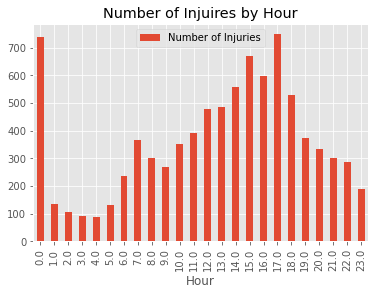

In [108]:
ac21[['Number of Injuries','Hour']].groupby('Hour').sum().sort_index().plot(kind='bar')

plt.title('Number of Injuires by Hour')

Text(0.5, 1.0, 'Number of Injuires by Weekday')

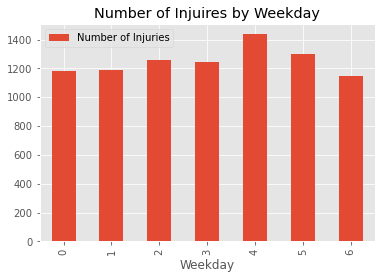

In [248]:
ac21[['Number of Injuries','Weekday']].groupby('Weekday').sum().sort_index().plot(kind='bar')

plt.title('Number of Injuires by Weekday')

Text(0.5, 1.0, 'Number of Injuires by Month')

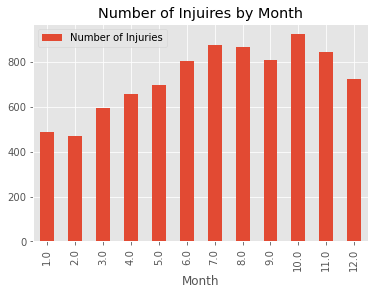

In [247]:
ac21[['Number of Injuries','Month']].groupby('Month').sum().sort_index().plot(kind='bar')

plt.title('Number of Injuires by Month')

In [299]:
# Creates a model
data = ac21.copy()[['Number of Injuries', 'Month', 'Weekday', 'Hour']]
data = data.groupby([ 'Month', 'Weekday', 'Hour']).sum()
data.reset_index(inplace=True)

data.rename(columns={'Number of Injuries': 'Inj'}, inplace=True)

data['Month'] = data['Month'].astype('str')
data['Weekday'] = data['Weekday'].astype('str')
data['Hour'] = data['Hour'].astype('str')

data = pd.concat([data, pd.get_dummies( data[['Month', 'Weekday', 'Hour']] )] , axis=1)

data.columns

Index(['Month', 'Weekday', 'Hour', 'Inj', 'Month_1.0', 'Month_10.0',
       'Month_11.0', 'Month_12.0', 'Month_2.0', 'Month_3.0', 'Month_4.0',
       'Month_5.0', 'Month_6.0', 'Month_7.0', 'Month_8.0', 'Month_9.0',
       'Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4',
       'Weekday_5', 'Weekday_6', 'Hour_0.0', 'Hour_1.0', 'Hour_10.0',
       'Hour_11.0', 'Hour_12.0', 'Hour_13.0', 'Hour_14.0', 'Hour_15.0',
       'Hour_16.0', 'Hour_17.0', 'Hour_18.0', 'Hour_19.0', 'Hour_2.0',
       'Hour_20.0', 'Hour_21.0', 'Hour_22.0', 'Hour_23.0', 'Hour_3.0',
       'Hour_4.0', 'Hour_5.0', 'Hour_6.0', 'Hour_7.0', 'Hour_8.0', 'Hour_9.0'],
      dtype='object')

In [300]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

factors = ['Month_1.0', 'Month_10.0', 'Month_11.0', 'Month_12.0',
       'Month_2.0', 'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0',
       'Month_7.0', 'Month_8.0', 'Month_9.0', 'Weekday_0', 'Weekday_1',
       'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6',
       'Hour_0.0', 'Hour_1.0', 'Hour_10.0', 'Hour_11.0', 'Hour_12.0',
       'Hour_13.0', 'Hour_14.0', 'Hour_15.0', 'Hour_16.0', 'Hour_17.0',
       'Hour_18.0', 'Hour_19.0', 'Hour_2.0', 'Hour_20.0', 'Hour_21.0',
       'Hour_22.0', 'Hour_23.0', 'Hour_3.0', 'Hour_4.0']

x_data = np.asarray(data[factors])
y_data = np.asarray(data['Inj'])

x_data = np.nan_to_num(x_data)
y_data = np.nan_to_num(y_data)

y_data = y_data.astype('float32')

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [314]:
from sklearn.ensemble import GradientBoostingRegressor

def auto_tune_gb(init_vals):
    params = {}
    params['subsample'] = [.05, .1, .25, .2, .25, .3]
    params['max_depth'] = [2, 3, 4]
    params['learning_rate'] = [0.01, 0.005, 0.002]
    params['n_estimators'] = [500, 700, 1000]
    params['loss'] = ['ls', 'lad', 'huber', 'quantile']

    best_vals = init_vals
    print('Start Values', best_vals)

    for i, param in enumerate(params.keys()):
        param_list = params[param]
        value_scores = pd.DataFrame({'value':param_list})

        for j, values in enumerate(param_list):
            j_vals = best_vals
            j_vals[i] = values
            
            model = GradientBoostingRegressor(subsample = j_vals[0],
                                              max_depth = j_vals[1],
                                              learning_rate = j_vals[2],
                                              n_estimators = j_vals[3],
                                              loss = j_vals[4],
                                              random_state=42)

            scores = cross_val_score(model, x_data, y_data, cv=8, scoring='r2').mean()
            value_scores.loc[j,'score'] = scores

        max_score = value_scores['score'].max()
        k = value_scores[value_scores['score'] == max_score].index
        best_val = value_scores.loc[k,'value'].to_list()[0]

        best_vals[i] = best_val
        print('Updated Values', best_vals, 'Score:', round(max_score, 3))

    return best_vals

init_list = [0.05, 3, 0.005, 1000, 'lad']

for i in range(1,4):
    print('Round:', i)
    init_list = auto_tune_gb(init_list)



Round: 1
Start Values [0.05, 3, 0.005, 1000, 'lad']
Updated Values [0.1, 3, 0.005, 1000, 'lad'] Score: 0.171
Updated Values [0.1, 4, 0.005, 1000, 'lad'] Score: 0.189
Updated Values [0.1, 4, 0.01, 1000, 'lad'] Score: 0.195
Updated Values [0.1, 4, 0.01, 700, 'lad'] Score: 0.199
Updated Values [0.1, 4, 0.01, 700, 'ls'] Score: 0.212
Round: 2
Start Values [0.1, 4, 0.01, 700, 'ls']
Updated Values [0.2, 4, 0.01, 700, 'ls'] Score: 0.216
Updated Values [0.2, 4, 0.01, 700, 'ls'] Score: 0.216
Updated Values [0.2, 4, 0.01, 700, 'ls'] Score: 0.216
Updated Values [0.2, 4, 0.01, 700, 'ls'] Score: 0.216
Updated Values [0.2, 4, 0.01, 700, 'huber'] Score: 0.216
Round: 3
Start Values [0.2, 4, 0.01, 700, 'huber']
Updated Values [0.25, 4, 0.01, 700, 'huber'] Score: 0.219
Updated Values [0.25, 4, 0.01, 700, 'huber'] Score: 0.219
Updated Values [0.25, 4, 0.01, 700, 'huber'] Score: 0.219
Updated Values [0.25, 4, 0.01, 700, 'huber'] Score: 0.219
Updated Values [0.25, 4, 0.01, 700, 'huber'] Score: 0.219


In [307]:
from sklearn.neural_network import MLPRegressor

def auto_tune_nn(init_vals):
    params = {}
    params['activation'] = ['identity', 'logistic', 'tanh', 'relu']
    params['solver'] = ['lbfgs', 'sgd', 'adam']
    params['alpha'] = [1, 0.1, 0.01, 0.001]
    params['hidden_layer_sizes'] = [2, 4, 6, 8, (6,3), (4,2)]
    params['max_iter'] = [5000]

    best_vals = init_vals

    print('Start Values', best_vals)

    for i, param in enumerate(params.keys()):
        param_list = params[param]
        value_scores = pd.DataFrame({'value':param_list})

        for j, values in enumerate(param_list):
            j_vals = best_vals
            j_vals[i] = values
            
            model = MLPRegressor(activation = j_vals[0], 
                                 solver = j_vals[1], 
                                 alpha = j_vals[2], 
                                 hidden_layer_sizes = j_vals[3], 
                                 max_iter = j_vals[4],
                                 random_state = 42)

            scores = cross_val_score(model, x_data, y_data, cv=8, scoring='r2').mean()
            value_scores.loc[j,'score'] = scores

        max_score = value_scores['score'].max()
        k = value_scores[value_scores['score'] == max_score].index
        best_val = value_scores.loc[k,'value'].to_list()[0]

        best_vals[i] = best_val
        print('Updated Values', best_vals, 'Score:', round(max_score, 3))

    return best_vals

init_list = ['identity', 'sgd', 0.01, 2, 5000]

for i in range(1,4):
    print('Round:', i)
    init_list = auto_tune_nn(init_list)

Round: 1
Start Values ['identity', 'sgd', 0.01, 2, 5000]


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Updated Values ['identity', 'sgd', 0.01, 2, 5000] Score: 0.226
Updated Values ['identity', 'sgd', 0.01, 2, 5000] Score: 0.226
Updated Values ['identity', 'sgd', 1.0, 2, 5000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 5000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Round: 2
Start Values ['identity', 'sgd', 1.0, 2, 1000]


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/pyth

Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Round: 3
Start Values ['identity', 'sgd', 1.0, 2, 1000]


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/pyth

Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227
Updated Values ['identity', 'sgd', 1.0, 2, 1000] Score: 0.227


In [288]:
y_data

array([0.07692308, 0.        , 1.        , ..., 1.25      , 1.5       ,
       0.75      ], dtype=float32)

In [315]:
# Compares the models to the real data graphicaly
model = GradientBoostingRegressor(subsample = 0.25,
                                  max_depth = 4,
                                  learning_rate = 0.01,
                                  n_estimators = 700,
                                  loss = 'huber',
                                  random_state=42)

model.fit(x_data, y_data)
data['GB_Preds'] = model.predict(x_data)

model = MLPRegressor(activation = 'identity', 
                     solver = 'sgd', 
                     alpha = 1, 
                     hidden_layer_sizes = 2, 
                     max_iter = 1000,
                     random_state = 42) 

model.fit(x_data, y_data)
data['NN_Preds'] = model.predict(x_data)

data.head()

,Month,Weekday,Hour,Inj,Month_1.0,Month_10.0,Month_11.0,Month_12.0,Month_2.0,Month_3.0,...,Hour_3.0,Hour_4.0,Hour_5.0,Hour_6.0,Hour_7.0,Hour_8.0,Hour_9.0,nn_preds,GB_Preds,NN_Preds
0,1.0,0,0.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,6.996845,4.491578,6.996845
1,1.0,0,1.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.047664,0.980657,-0.047664
2,1.0,0,2.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.189810,0.686761,-0.189810
3,1.0,0,3.0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,-0.456407,0.188014,-0.456407
4,1.0,0,4.0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,-0.570304,0.222641,-0.570304


Text(0.5, 1.0, 'Number of Injuires per Hour by Month')

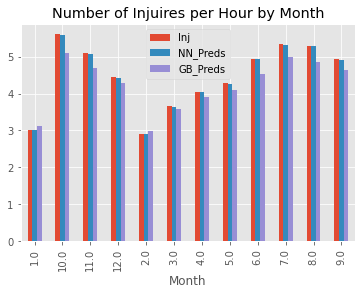

In [316]:
data[['Inj', 'NN_Preds', 'GB_Preds', 'Month']].groupby('Month').mean().sort_index().plot(kind='bar')

plt.title('Number of Injuires per Hour by Month')

Text(0.5, 1.0, 'Number of Injuires by Weekday')

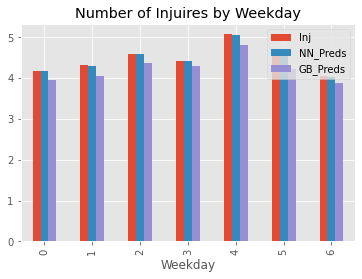

In [317]:
data[['Inj', 'NN_Preds', 'GB_Preds', 'Weekday']].groupby('Weekday').mean().sort_index().plot(kind='bar')

plt.title('Number of Injuires by Weekday')

Text(0.5, 1.0, 'Number of Injuires by Hour')

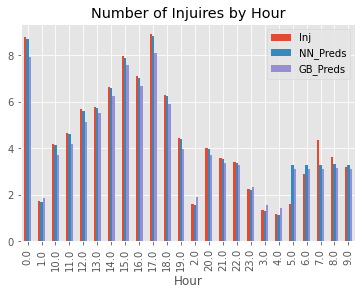

In [318]:
data[['Inj', 'NN_Preds', 'GB_Preds', 'Hour']].groupby('Hour').mean().sort_index().plot(kind='bar')

plt.title('Number of Injuires by Hour')

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Actual v. Predicted Values')

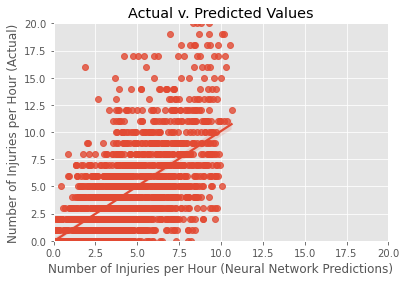

In [323]:
sns.regplot('NN_Preds', 'Inj', data)

plt.xlabel('Number of Injuries per Hour (Neural Network Predictions)')
plt.ylabel('Number of Injuries per Hour (Actual)')

plt.xlim(0,20)
plt.ylim(0,20)

plt.title('Actual v. Predicted Values')